In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix,plot_confusion_matrix, plot_roc_curve

In [2]:
df = pd.read_csv('Bank_Customer_Churn_dataset.csv')
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


## Clearly RowNumber, CustomerId, Surname won't have any impact on customer churn so we'll drop them

In [3]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

## Checking for any null values

In [4]:
df.isnull().any().sum()

0

In [5]:
df.dtypes

CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
CreditScore,10000.0,650.528800,96.653299,350.00,584.00,652.000,718.0000,850.00
Age,10000.0,38.921800,10.487806,18.00,32.00,37.000,44.0000,92.00
Tenure,10000.0,5.012800,2.892174,0.00,3.00,5.000,7.0000,10.00
Balance,10000.0,76485.889288,62397.405202,0.00,0.00,97198.540,127644.2400,250898.09
NumOfProducts,10000.0,1.530200,0.581654,1.00,1.00,1.000,2.0000,4.00
HasCrCard,10000.0,0.705500,0.455840,0.00,0.00,1.000,1.0000,1.00
IsActiveMember,10000.0,0.515100,0.499797,0.00,0.00,1.000,1.0000,1.00
EstimatedSalary,10000.0,100090.239881,57510.492818,11.58,51002.11,100193.915,149388.2475,199992.48
Exited,10000.0,0.203700,0.402769,0.00,0.00,0.000,0.0000,1.00


In [7]:
df['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [8]:
df['Geography'].value_counts()

France     5014
Germany    2509
Spain      2477
Name: Geography, dtype: int64

## Visualizing our data

<AxesSubplot:>

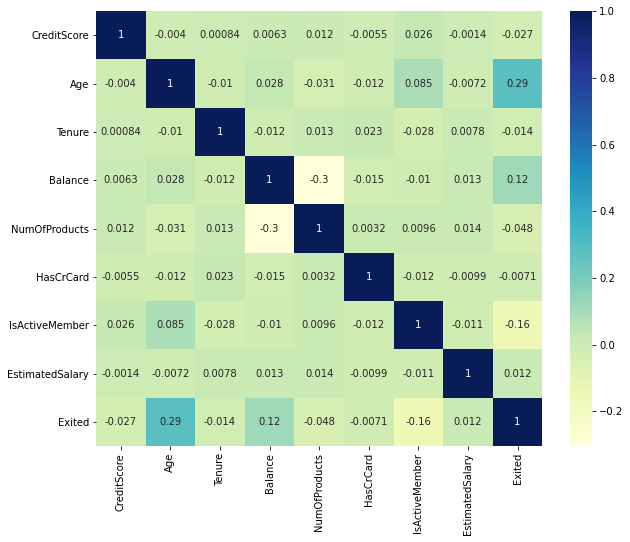

In [9]:
plt.figure(figsize = (10,8))
sns.heatmap(df.corr(), annot=True, cmap = 'YlGnBu')

#### None of the attributes are highly correlated 

<AxesSubplot:xlabel='Exited', ylabel='CreditScore'>

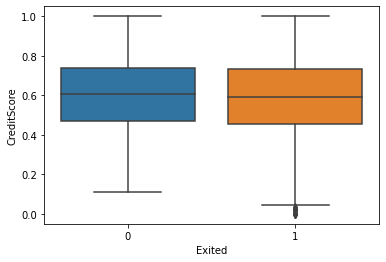

In [51]:
sns.boxplot(y=df['CreditScore'],x=df['Exited'])

<AxesSubplot:xlabel='Exited', ylabel='Age'>

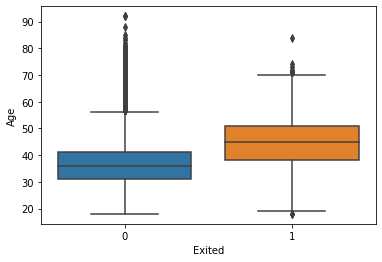

In [11]:
sns.boxplot(y=df['Age'], x=df['Exited'])

#### Bank churn is noticeably higher for the older demographic

<AxesSubplot:xlabel='IsActiveMember', ylabel='count'>

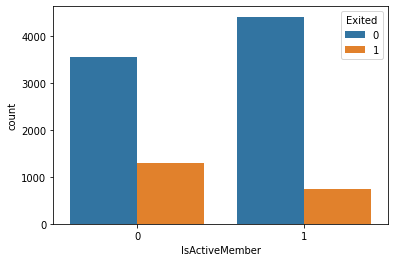

In [56]:
sns.countplot(x=df['IsActiveMember'], hue = df['Exited'])

#### Oddly, active members churn more than inactive ones

In [12]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

enc = LabelEncoder()
continuous_features = ['CreditScore','Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']
df['Geography'] = enc.fit_transform(df['Geography'])
df['Gender'] = enc.fit_transform(df['Gender'])

In [13]:
scaler = MinMaxScaler()
df[continuous_features] = scaler.fit_transform(df[continuous_features])

In [14]:
df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,0.538,0,0,0.324324,0.2,0.000000,0.000000,1,1,0.506735,1
1,0.516,2,0,0.310811,0.1,0.334031,0.000000,0,1,0.562709,0
2,0.304,0,0,0.324324,0.8,0.636357,0.666667,1,0,0.569654,1
3,0.698,0,0,0.283784,0.1,0.000000,0.333333,0,0,0.469120,0
4,1.000,2,0,0.337838,0.2,0.500246,0.000000,1,1,0.395400,0


### Splitting the data

In [15]:
X = df.drop(['Exited'], axis=1)
y = df['Exited']

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

In [17]:
X_train.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
4901,0.646,0,1,0.554054,0.0,0.709683,0.333333,0,1,0.105271
4375,1.000,1,1,0.310811,0.8,0.242651,0.000000,1,0,0.159086
6698,0.750,0,0,0.175676,0.6,0.000000,0.000000,0,0,0.306604
9805,0.588,0,1,0.202703,0.7,0.695786,0.000000,0,1,0.219679
1101,0.706,2,1,0.148649,0.9,0.000000,0.333333,1,0,0.253364


### Trying different models

##### KNeighborsClassifier

In [18]:
knn_clf = KNeighborsClassifier(n_neighbors = 5, weights = 'uniform', metric = 'euclidean').fit(X_train, y_train)

In [19]:
print(knn_clf.score(X_test,y_test))

0.8172


##### Logistic Regression

In [20]:
log_reg = LogisticRegression(random_state = 42).fit(X_train, y_train)

In [21]:
print(log_reg.score(X_test, y_test))

0.812


##### DecisionTreeClassifer

In [22]:
dt_clf = DecisionTreeClassifier().fit(X_train,y_train)

In [23]:
print(dt_clf.score(X_test,y_test))

0.7972


##### RandomForestClassifier

In [24]:
rf_clf = RandomForestClassifier().fit(X_train,y_train)

In [25]:
print(rf_clf.score(X_test, y_test))

0.8656


In [26]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'bootstrap': [True],
    'max_depth': [100, 125, 150, 175],
    'max_features': [2, 4, 6,],
    'min_samples_leaf': [3, 4, 5],
    'min_samples_split': [8, 10, 12],
    'n_estimators': [100, 150, 200]
}

rf_clf2 = RandomForestClassifier()
grid_search = GridSearchCV(estimator = rf_clf2, param_grid = param_grid, cv = 3, n_jobs = -1)

In [27]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'bootstrap': [True], 'max_depth': [100, 125, 150, 175],
                         'max_features': [2, 4, 6],
                         'min_samples_leaf': [3, 4, 5],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 150, 200]})

In [28]:
grid_search.best_params_

{'bootstrap': True,
 'max_depth': 175,
 'max_features': 4,
 'min_samples_leaf': 3,
 'min_samples_split': 8,
 'n_estimators': 150}

In [59]:
rf_clf2 = RandomForestClassifier(bootstrap=True, max_depth=175, max_features=4, 
                                 min_samples_leaf=3, min_samples_split=8, n_estimators=150).fit(X_train, y_train)
print(rf_clf2.score(X_test, y_test))

0.868


------------Metrics-----------------
Accuracy----------0.868
Precision---------0.7755775577557755
Recall------------0.47283702213279677
F1----------------0.5875


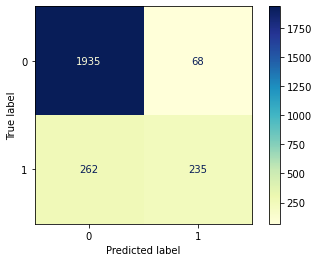

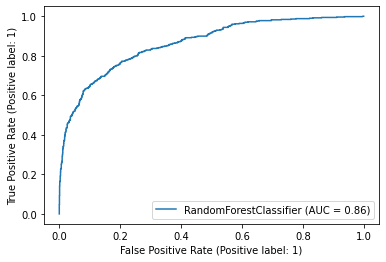

In [60]:
y_pred = rf_clf2.predict(X_test)
cm = confusion_matrix(y_test,y_pred)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print('------------Metrics-----------------')
print(f'Accuracy----------{accuracy}')
print(f'Precision---------{precision}')
print(f'Recall------------{recall}')
print(f'F1----------------{f1}')

plot_confusion_matrix(rf_clf2, X_test, y_test, cmap = 'YlGnBu')
plot_roc_curve(rf_clf2, X_test, y_test)
plt.show()